<a href="https://colab.research.google.com/github/gbcarneiro/lunar-lander/blob/main/20240407_Gabriel_Carneiro_Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00


In [2]:
pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=8cf192e7f8f2e53f39fe9cb5184d018ed043b940188cf4705674238f77f35fbd
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


Importando as bibliotecas do gym

In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random



Implementando o Q-Learning

In [34]:

# Definição de hiperparâmetros
TAMANHO_BUFFER = int(1e5)  # tamanho do buffer de replay
TAMANHO_BATCH = 64         # tamanho do batch
GAMMA = 0.99               # fator de desconto
TAU = 1e-3                 # parâmetro para atualização suave dos parâmetros da rede alvo
LR = 5e-4                  # taxa de aprendizado
UPDATE_EVERY = 4           # frequência de atualização da rede

# Define o dispositivo para treinamento (cuda ou cpu)
dispositivo = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Definição da rede neural para Q-Learning
class QNetwork(nn.Module):
  def __init__(self, tamanho_estado, tamanho_acao, seed):
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)

    # Definição das camadas
    self.fc1 = nn.Linear(tamanho_estado, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, tamanho_acao)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

# Implementação do Replay Buffer
class ReplayBuffer:
  def __init__(self, tamanho_buffer, tamanho_batch, seed):
    self.memoria = deque(maxlen=tamanho_buffer)
    self.tamanho_batch = tamanho_batch
    self.experiencia = namedtuple("Experiencia", field_names=["estado", "acao", "recompensa", "proximo_estado", "finalizado"])
    self.seed = random.seed(seed)

  def add(self, estado, acao, recompensa, proximo_estado, finalizado):
    e = self.experiencia(estado, acao, recompensa, proximo_estado, finalizado)
    self.memoria.append(e)

  def sample(self):
    experiencias = random.sample(self.memoria, k=self.tamanho_batch)

    estados = torch.from_numpy(np.vstack([e.estado for e in experiencias if e is not None])).float().to(dispositivo)
    acoes = torch.from_numpy(np.vstack([e.acao for e in experiencias if e is not None])).long().to(dispositivo)
    recompensas = torch.from_numpy(np.vstack([e.recompensa for e in experiencias if e is not None])).float().to(dispositivo)
    proximos_estados = torch.from_numpy(np.vstack([e.proximo_estado for e in experiencias if e is not None])).float().to(dispositivo)
    finalizados = torch.from_numpy(np.vstack([e.finalizado for e in experiencias if e is not None]).astype(np.uint8)).float().to(dispositivo)

    return (estados, acoes, recompensas, proximos_estados, finalizados)

  def __len__(self):
    return len(self.memoria)

# Implementação do Agente DQN
class DQNAgent:
  def __init__(self, tamanho_estado, tamanho_acao, seed):
      self.tamanho_estado = tamanho_estado
      self.tamanho_acao = tamanho_acao
      self.seed = random.seed(seed)

      # Redes Q e Q fixa
      self.rede_local = QNetwork(tamanho_estado, tamanho_acao, seed).to(dispositivo)
      self.rede_alvo = QNetwork(tamanho_estado, tamanho_acao, seed).to(dispositivo)
      self.otimizador = optim.Adam(self.rede_local.parameters(), lr=LR)

      # Replay memory
      self.memoria = ReplayBuffer(TAMANHO_BUFFER, TAMANHO_BATCH, seed)
      # Contador de tempo
      self.t_passo = 0

  def atualizar_rede_fixa(self):
    for parametro_alvo, parametro_local in zip(self.rede_alvo.parameters(), self.rede_local.parameters()):
      parametro_alvo.data.copy_(TAU * parametro_local.data + (1.0 - TAU) * parametro_alvo.data)

  def step(self, estado, acao, recompensa, proximo_estado, finalizado):
    # Salva a experiência no buffer de replay
    self.memoria.add(estado, acao, recompensa, proximo_estado, finalizado)

    # Aprende a cada UPDATE_EVERY passos de tempo
    self.t_passo = (self.t_passo + 1) % UPDATE_EVERY

    if self.t_passo == 0:

      # Se houver amostras suficientes, obtém uma amostra aleatória do buffer de replay
      if len(self.memoria) > TAMANHO_BATCH:
        experiencias = self.memoria.sample()
        self.learn(experiencias, GAMMA)

  def learn(self, experiencias, gamma):
    estados, acoes, recompensas, proximos_estados, finalizados = experiencias

    # Obtém os Q valores máximos para os próximos estados da rede fixa
    Q_alvos_proximos = self.rede_alvo(proximos_estados).detach().max(1)[0].unsqueeze(1)
    # Calcula os Q targets para os estados atuais
    Q_alvos = recompensas + (gamma * Q_alvos_proximos * (1 - finalizados))

    # Obtém os Q valores esperados dos estados atuais da rede local
    Q_esperados = self.rede_local(estados).gather(1, acoes)

    # Computa a perda
    perda = F.mse_loss(Q_esperados, Q_alvos)

    # Minimiza a perda
    self.otimizador.zero_grad()
    perda.backward()
    self.otimizador.step()

    # Atualiza os pesos da rede fixa
    self.atualizar_rede_fixa()

  def act(self, estado, eps=0.0):
    estado = torch.from_numpy(estado).float().unsqueeze(0).to(dispositivo)
    self.rede_local.eval()

    with torch.no_grad():
        valores_acao = self.rede_local(estado)

    self.rede_local.train()

    # Seleciona a ação com base na política epsilon-greedy
    if random.random() > eps:
      return np.argmax(valores_acao.cpu().data.numpy())

    else:
      return random.choice(np.arange(self.tamanho_acao))

# Configurações do ambiente e criação do agente
env = gym.make('LunarLander-v2')
env.seed(0)
tamanho_estado = env.observation_space.shape[0]
tamanho_acao = env.action_space.n

# Criando o agente
agente = DQNAgent(tamanho_estado, tamanho_acao, seed=0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episódio 100	Média (últimos 100): -153.57
Episódio 200	Média (últimos 100): -70.60
Episódio 300	Média (últimos 100): 1.26
Episódio 400	Média (últimos 100): 16.07
Episódio 500	Média (últimos 100): 44.63
Episódio 600	Média (últimos 100): 55.07
Episódio 700	Média (últimos 100): 50.77
Episódio 800	Média (últimos 100): 68.02
Episódio 900	Média (últimos 100): 71.42
Episódio 1000	Média (últimos 100): 68.99


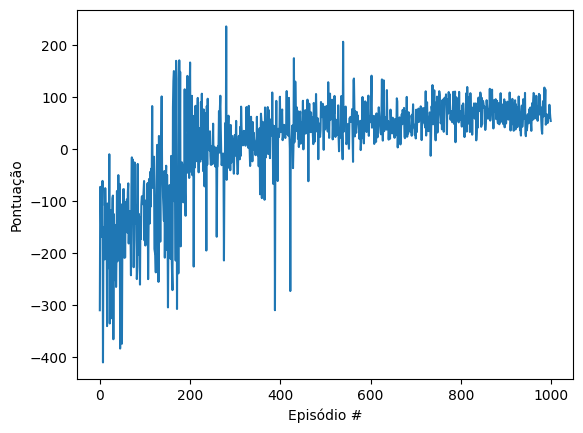

In [32]:
def treinar_agente(n_episodios=1000, max_t=500, eps_inicio=1.0, eps_fim=0.01, eps_decaimento=0.995):
  pontuacoes = []                           # lista para armazenar as pontuações de cada episódio
  pontuacoes_janela = deque(maxlen=100)     # mantém as últimas 100 pontuações
  eps = eps_inicio                          # inicializa o valor de epsilon

  for i_episodio in range(1, n_episodios+1):
    estado = env.reset()
    pontuacao = 0

    for t in range(max_t):
      acao = agente.act(estado, eps)
      proximo_estado, recompensa, finalizado, _ = env.step(acao)

      agente.step(estado, acao, recompensa, proximo_estado, finalizado)

      estado = proximo_estado
      pontuacao += recompensa

      if finalizado:
        break

    pontuacoes_janela.append(pontuacao)       # salva a pontuação mais recente
    pontuacoes.append(pontuacao)              # salva a pontuação do episódio
    eps = max(eps_fim, eps_decaimento*eps)    # reduz epsilon

    print('\rEpisódio {}\tMédia (últimos 100): {:.2f}'.format(i_episodio, np.mean(pontuacoes_janela)), end="")

    if i_episodio % 100 == 0:
      print('\rEpisódio {}\tMédia (últimos 100): {:.2f}'.format(i_episodio, np.mean(pontuacoes_janela)))

    if np.mean(pontuacoes_janela) >= 200.0:
      print('\nAmbiente resolvido em {:d} episódios!\tMédia (últimos 100): {:.2f}'.format(i_episodio-100, np.mean(pontuacoes_janela)))
      break

  return pontuacoes

# Treinamento do agente
pontuacoes = treinar_agente()

# Visualização do treinamento
plt.plot(np.arange(len(pontuacoes)), pontuacoes)
plt.ylabel('Pontuação')
plt.xlabel('Episódio #')
plt.show()

Plotando Video

In [36]:
from gym.wrappers import RecordVideo

# Criar o ambiente com modo de renderização 'rgb_array' e wrapper para gravação de vídeo
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env = RecordVideo(env, "videos/lunar-demo", episode_trigger=lambda episode: True)

# Criar um novo agente e carregar o modelo treinado
agente = DQNAgent(tamanho_estado, tamanho_acao, seed=0)
agente.rede_local.load_state_dict(torch.load('dqn_lunar_lander.pth'))

# Rodar o agente no ambiente
n_episodios = 5
for i_episodio in range(n_episodios):
    estado = env.reset()
    while True:
        acao = agente.act(estado, eps=0.0)
        proximo_estado, recompensa, finalizado, _ = env.step(acao)
        if finalizado:
            break
        estado = proximo_estado

# Fechar o ambiente
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
